# Matcha-TTS: A fast TTS architecture with conditional flow matching
---
[Shivam Mehta](https://www.kth.se/profile/smehta), [Ruibo Tu](https://www.kth.se/profile/ruibo), [Jonas Beskow](https://www.kth.se/profile/beskow), [Éva Székely](https://www.kth.se/profile/szekely), and [Gustav Eje Henter](https://people.kth.se/~ghe/)

We introduce Matcha-TTS, a new encoder-decoder architecture for speedy TTS acoustic modelling, trained using optimal-transport conditional flow matching (OT-CFM). This yields an ODE-based decoder capable of high output quality in fewer synthesis steps than models trained using score matching. Careful design choices additionally ensure each synthesis step is fast to run. The method is probabilistic, non-autoregressive, and learns to speak from scratch without external alignments. Compared to strong pre-trained baseline models, the Matcha-TTS system has the smallest memory footprint, rivals the speed of the fastest models on long utterances, and attains the highest mean opinion score in a listening test.

Demo Page: https://shivammehta25.github.io/Matcha-TTS \
Code: https://github.com/shivammehta25/Matcha-TTS




In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import datetime as dt
from pathlib import Path

import IPython.display as ipd
import numpy as np
import soundfile as sf
import torch
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lightning import seed_everything

# Hifigan imports
from matcha.hifigan.config import v1
from matcha.hifigan.denoiser import Denoiser
from matcha.hifigan.env import AttrDict
from matcha.hifigan.models import Generator as HiFiGAN
# Matcha imports
from matcha.models.matcha_tts import MatchaTTS
from matcha.text import sequence_to_text, text_to_sequence
from matcha.utils.model import denormalize
from matcha.utils.utils import get_user_data_dir, intersperse

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# This allows for real time code changes being reflected in the notebook, no need to restart the kernel

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Filepaths

In [5]:
# MATCHA_CHECKPOINT = "logs/train/hi-fi_en-US_female_piper_phonemizer/runs/2023-12-01_12-14-06/checkpoints/last.ckpt"
# MATCHA_CHECKPOINT = get_user_data_dir()/"matcha_ljspeech.ckpt
MATCHA_CHECKPOINT = "logs/train/tsg2_stoc_dur/runs/2024-01-05_12-35-07/checkpoints/last.ckpt"
HIFIGAN_CHECKPOINT = get_user_data_dir() / "hifigan_T2_v1"
OUTPUT_FOLDER = "synth_output"

## Load Matcha-TTS

In [6]:
def load_model(checkpoint_path):
    model = MatchaTTS.load_from_checkpoint(checkpoint_path, map_location=device)
    model.eval()
    return model
count_params = lambda x: f"{sum(p.numel() for p in x.parameters()):,}"


model = load_model(MATCHA_CHECKPOINT)
print(f"Model loaded! Parameter count: {count_params(model)}")

Model loaded! Parameter count: 18,336,545


## Load HiFi-GAN (Vocoder)

In [7]:
def load_vocoder(checkpoint_path):
    h = AttrDict(v1)
    hifigan = HiFiGAN(h).to(device)
    hifigan.load_state_dict(torch.load(checkpoint_path, map_location=device)['generator'])
    _ = hifigan.eval()
    hifigan.remove_weight_norm()
    return hifigan

vocoder = load_vocoder(HIFIGAN_CHECKPOINT)
denoiser = Denoiser(vocoder, mode='zeros')

Removing weight norm...


### Helper functions to synthesise

In [8]:
@torch.inference_mode()
def process_text(text: str):
    x = torch.tensor(intersperse(text_to_sequence(text, ['english_cleaners2']), 0),dtype=torch.long, device=device)[None]
    x_lengths = torch.tensor([x.shape[-1]],dtype=torch.long, device=device)
    x_phones = sequence_to_text(x.squeeze(0).tolist())
    return {
        'x_orig': text,
        'x': x,
        'x_lengths': x_lengths,
        'x_phones': x_phones
    }


@torch.inference_mode()
def synthesise(text, spks=None):
    text_processed = process_text(text)
    start_t = dt.datetime.now()
    output = model.synthesise(
        text_processed['x'], 
        text_processed['x_lengths'],
        n_timesteps=n_timesteps,
        temperature=temperature,
        spks=spks,
        length_scale=length_scale
    )
    # merge everything to one dict    
    output.update({'start_t': start_t, **text_processed})
    return output

@torch.inference_mode()
def to_waveform(mel, vocoder):
    audio = vocoder(mel).clamp(-1, 1)
    audio = denoiser(audio.squeeze(0), strength=0.00025).cpu().squeeze()
    return audio.cpu().squeeze()
    
def save_to_folder(filename: str, output: dict, folder: str):
    folder = Path(folder)
    folder.mkdir(exist_ok=True, parents=True)
    np.save(folder / f'{filename}', output['mel'].cpu().numpy())
    sf.write(folder / f'{filename}.wav', output['waveform'], 22050, 'PCM_24')

def plot_spectrogram(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram.squeeze().cpu().numpy(), aspect="auto", origin="lower", interpolation="none")
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    plt.show()

## Setup text to synthesise

In [30]:
texts = [
    "; What I used to do this is crazy I was destroying my skin, ; in the mornings because I used to hate sweating, because that would make my skin oily; and that will block my pores and that will give me more spots.",
    "; What I used to do this is crazy I was destroying my skin, ; in the mornings because I used to hate sweating, because that would make my skin oily; and that will block my pores and that will give me more spots.",
    "; What I used to do this is crazy I was destroying my skin, ; in the mornings because I used to hate sweating, because that would make my skin oily; and that will block my pores and that will give me more spots.",
    "; So I remember I ran as fast as I could I tried to get out; , between a; , The people as quickly as I could because I was like oh my god my stomach is just like, Killing me.",
    "; So I remember I ran as fast as I could I tried to get out; , between a; , The people as quickly as I could because I was like oh my god my stomach is just like, Killing me.",
    "; So I remember I ran as fast as I could I tried to get out; , between a; , The people as quickly as I could because I was like oh my god my stomach is just like, Killing me.",
    "; So I remember I ran as fast as I could I tried to get out; , between a; , The people as quickly as I could because I was like oh my god my stomach is just like, Killing me.",
    "that's only another story; Same story again same family This is the same family I'm telling you; Their house is haunted 100% haunted okay?; because they're.",
    "that's only another story; Same story again same family This is the same family I'm telling you; Their house is haunted 100% haunted okay?; because they're.",
    "that's only another story; Same story again same family This is the same family I'm telling you; Their house is haunted 100% haunted okay?; because they're.",
    "that's only another story; Same story again same family This is the same family I'm telling you; Their house is haunted 100% haunted okay?; because they're.",
    
    # "Optionally, the ONNIX exporter accepts vocoder-name and vocoder-checkpoint arguments, This enables you to embed the vocoder in the exported graph and generate waveforms in a single run, (similar to end-to-end TTS systems).",
]

### Hyperparameters

In [31]:
## Number of ODE Solver steps
n_timesteps = 10

## Changes to the speaking rate
length_scale=1.0

## Sampling temperature
temperature = 0.667

## Synthesis

  0%|          | 0/11 [00:00<?, ?it/s]

Global seed set to 1483


tensor([[[ 1.,  1.,  7.,  5.,  3.,  1.,  5.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  2.,  4.,  3.,  2.,  4.,  3.,  2.,  4.,  1.,  1.,  2.,  2.,
           4.,  1.,  2., 11.,  2.,  5.,  4.,  1.,  1.,  1.,  1.,  1.,  4.,  1.,
           1.,  3.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,
           3.,  4.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,
           2.,  1.,  2.,  2.,  3.,  4.,  3.,  1.,  3.,  1.,  2.,  4.,  2.,  2.,
           1.,  2.,  2.,  2.,  2.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,
           1.,  1.,  3.,  1.,  1.,  1.,  2.,  2.,  3.,  1.,  4.,  3.,  4., 15.,
          25.,  3.,  9., 14.,  5.,  1.,  3.,  1.,  2.,  4.,  1.,  1.,  2.,  1.,
           1.,  3.,  1.,  1.,  3.,  2.,  1.,  3.,  1.,  2.,  1.,  3.,  2.,  3.,
           4.,  3.,  2.,  3.,  1.,  2., 

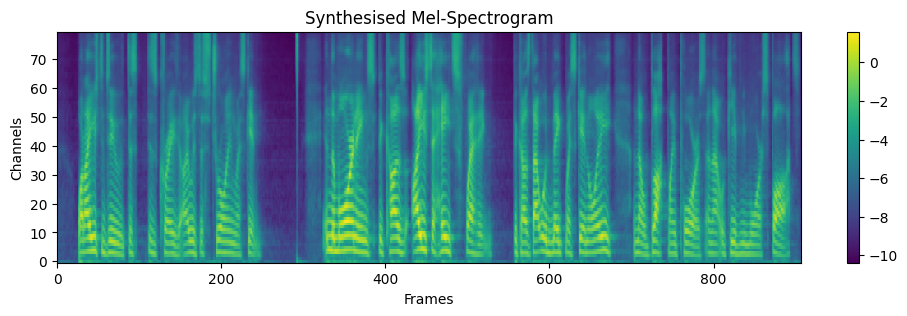

Global seed set to 2243


tensor([[[ 3.,  3.,  1.,  2.,  1.,  1.,  2.,  7.,  2.,  1.,  1.,  1.,  2.,  1.,
           3.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,
           1.,  2.,  2.,  6.,  2.,  3., 13.,  1.,  2.,  2.,  1.,  1.,  3.,  1.,
           5., 15.,  1.,  5.,  1.,  3.,  2.,  1.,  1.,  1.,  1.,  2.,  3.,  1.,
           1.,  2.,  1.,  2.,  3.,  2.,  1.,  2.,  4.,  1.,  2.,  1.,  3.,  4.,
           1.,  3.,  1.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
           1.,  1.,  2.,  2.,  3.,  6.,  2.,  2.,  2.,  1.,  2.,  2.,  5.,  2.,
           1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,
           1.,  2.,  2.,  1.,  1.,  1.,  2.,  3.,  1.,  3.,  7.,  5.,  5., 10.,
          26.,  5.,  7.,  7.,  7.,  2.,  2.,  1.,  1.,  1.,  3.,  1.,  2.,  1.,
           1.,  3.,  1.,  1.,  2.,  1.,  3.,  1.,  3.,  2.,  2.,  1.,  1.,  2.,
           3.,  2.,  3.,  4.,  2.,  1., 

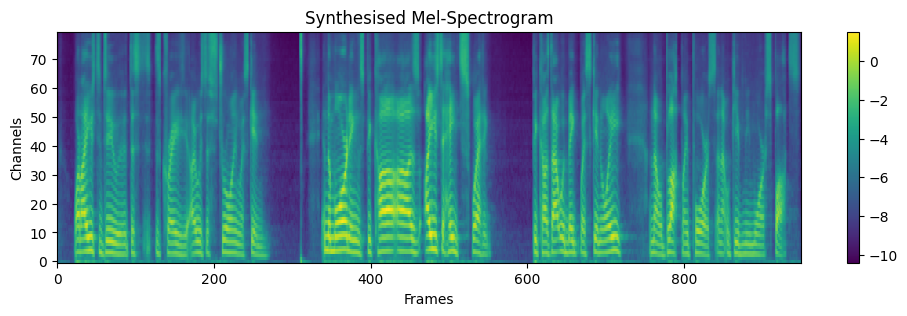

Global seed set to 7277


tensor([[[ 6.,  1.,  5., 13., 16.,  3.,  2.,  5.,  1.,  1.,  1.,  1.,  2.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  4.,  1.,
           2.,  1.,  2.,  1.,  3.,  3.,  5.,  5.,  2.,  3.,  1.,  2.,  2.,  1.,
           2.,  1.,  1.,  4.,  3.,  1.,  2.,  1.,  2.,  3.,  1.,  4.,  3.,  1.,
           1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
           1.,  1.,  2.,  2.,  4.,  7.,  6.,  1.,  2.,  1.,  3.,  2.,  5.,  1.,
           2.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  2.,  2.,  1.,  1.,  1.,  5.,  2.,  2.,  3.,  3., 15., 25.,
          12.,  4.,  8., 26.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  1.,
           2.,  3.,  1.,  1.,  2.,  1.,  2.,  1.,  3.,  1.,  4.,  1.,  2.,  2.,
           3.,  2.,  2.,  2.,  1.,  2., 

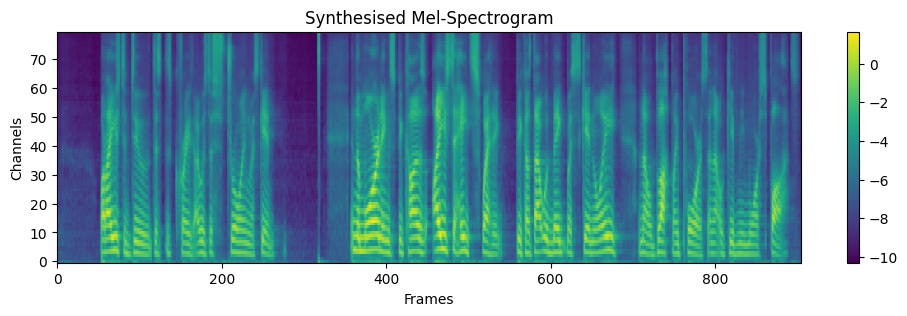

Global seed set to 3959


tensor([[[ 3., 11.,  1.,  1.,  3.,  4.,  4.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,
           1.,  2.,  2.,  1.,  1.,  1.,  2.,  5.,  1.,  2.,  2.,  7.,  8.,  3.,
           2.,  4., 11.,  5.,  1.,  4.,  1.,  1.,  2.,  3.,  3.,  1.,  1.,  3.,
           7.,  3.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,
           2.,  3.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  3.,  3.,
           2.,  3.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  2.,  1.,
           1.,  1.,  2.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  3.,  4.,  5.,  4.,
           4.,  3.,  5.,  2.,  7., 10.,  1.,  2.,  1.,  2.,  3.,  2., 10.,  1.,
           1.,  4.,  2.,  2.,  3.,  1.,  1.,  2.,  2.,  6.,  4.,  4.,  2.,  1.,
           1.,  2.,  3.,  7., 19.,  9., 

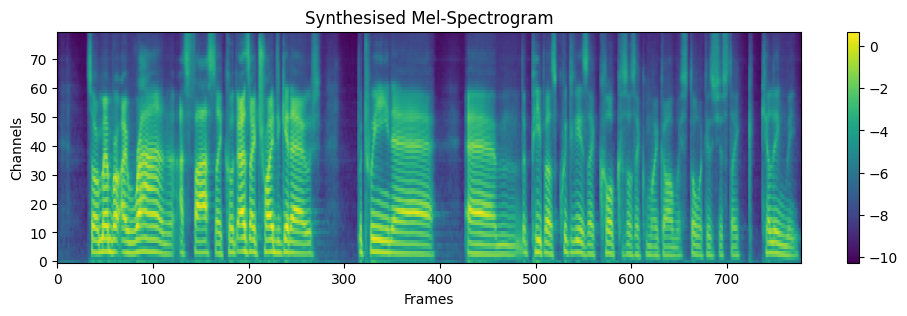

Global seed set to 2505


tensor([[[10.,  1.,  1.,  1.,  6.,  1.,  2., 14.,  1.,  1.,  2.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  2.,  1.,  3.,
           1.,  2.,  1.,  3.,  1.,  1.,  1.,  5.,  1.,  2.,  1.,  3.,  6., 10.,
           6.,  3.,  4.,  3.,  2.,  7.,  2.,  2.,  4.,  3.,  3.,  1.,  1.,  2.,
           6.,  2.,  2.,  1.,  1.,  3.,  2.,  1.,  1.,  1.,  3.,  1.,  2.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 13.,  2., 12.,  4.,
           2.,  3.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,
           1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,
           1.,  1.,  1.,  1.,  1.,  3.,  2.,  1.,  1.,  3.,  2.,  3.,  3.,  4.,
           4.,  1., 10.,  2.,  3.,  8.,  1.,  5.,  6.,  3.,  4.,  6.,  7.,  1.,
           1.,  5.,  2.,  1.,  2.,  1.,  2.,  2.,  3.,  2.,  2.,  3.,  2.,  1.,
           1.,  1.,  4.,  3.,  7.,  7., 

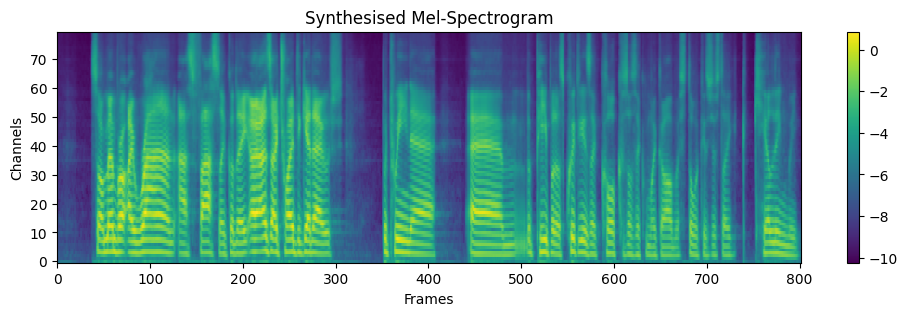

Global seed set to 4942


tensor([[[ 3.,  1.,  3., 10.,  3.,  6.,  3.,  4.,  1.,  1.,  2.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,
           1.,  3.,  3.,  1.,  3.,  1.,  3.,  3.,  1.,  2.,  2.,  3.,  6.,  5.,
           2.,  2.,  5.,  5.,  1.,  2.,  1.,  1.,  2.,  1.,  3.,  1.,  1.,  3.,
           4.,  3.,  1.,  1.,  2.,  4.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  3.,
           1.,  4.,  2.,  1.,  2.,  1.,  1.,  1.,  5.,  1.,  8.,  3.,  4.,  6.,
           2.,  4.,  1.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  3.,  1.,
           1.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,
           1.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  2.,  3.,  3.,
           5.,  2.,  8.,  2.,  8.,  2.,  3.,  5.,  1.,  3.,  3.,  4.,  2.,  1.,
           1.,  4.,  2.,  2.,  3.,  1.,  5.,  1.,  3.,  4.,  5.,  4.,  3.,  3.,
           2.,  2.,  4.,  4.,  5., 11., 

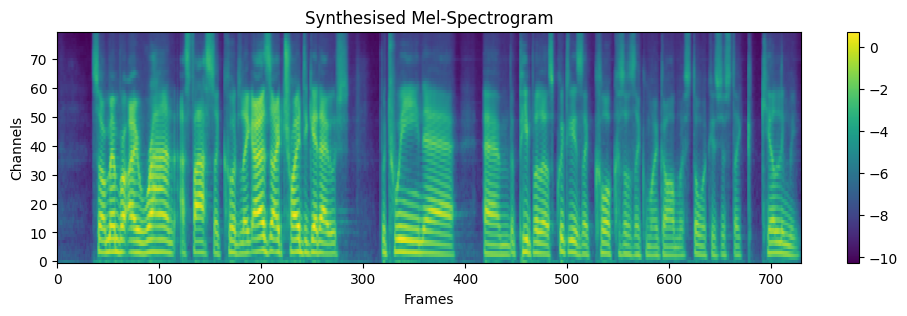

Global seed set to 195


tensor([[[ 5.,  7.,  1.,  1., 13.,  4.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  4.,  1.,
           1.,  2.,  2.,  1.,  1.,  1.,  4.,  2.,  1.,  2.,  4.,  7.,  6.,  7.,
           3.,  3.,  2.,  2.,  2.,  2.,  1.,  2.,  3.,  7.,  5.,  1.,  1.,  1.,
           4.,  5.,  3.,  1.,  2.,  3.,  1.,  1.,  2.,  2.,  4.,  2.,  2.,  1.,
           1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,  7.,  4.,
           3.,  2.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,
           1.,  1.,  2.,  2.,  2.,  4.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,
           1.,  1.,  1.,  1.,  2.,  2.,  2.,  1.,  1.,  3.,  1.,  3.,  3.,  2.,
           3.,  2.,  3.,  1.,  8.,  1.,  7.,  4.,  2.,  4.,  7.,  4.,  4.,  1.,
           1.,  6.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  4.,  4.,  1.,  1.,
           1.,  2.,  5.,  4.,  8., 12., 

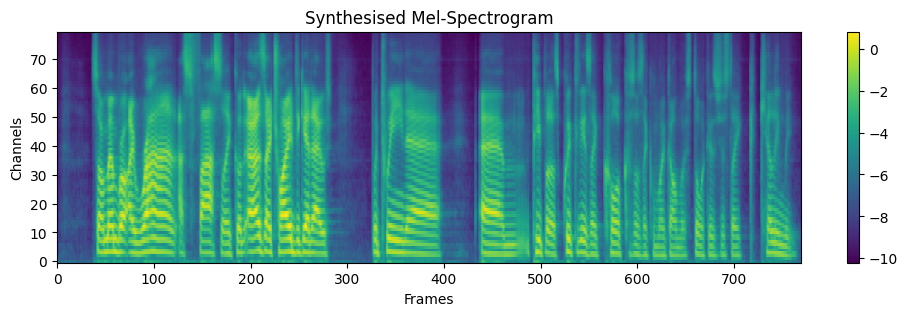

Global seed set to 9757


tensor([[[ 3.,  2.,  1.,  3.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,
           2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
           1.,  2.,  2.,  2.,  1.,  1.,  2.,  1.,  3.,  2.,  1.,  1.,  1.,  1.,
           1.,  3.,  2.,  1.,  1.,  3.,  2.,  2.,  2.,  2.,  4., 17.,  5.,  4.,
           1.,  4.,  1.,  1.,  1.,  2.,  2.,  1.,  2.,  1.,  1.,  1.,  2.,  2.,
           3.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  2.,  2.,  2.,
           1.,  1.,  3.,  1.,  2.,  2.,  3.,  2.,  2.,  3.,  1.,  1.,  2.,  8.,
           1.,  1.,  2.,  2.,  1.,  1.,  3.,  1.,  1.,  1.,  3.,  1.,  2.,  1.,
           3.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  1., 10.,  1.,  1.,  1.,  1.,
           1.,  3.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  2.,  2.,  5.,  1.,  2.,  2.,  4.,  1.,  3.,  1.,  1.,  2.,
           1.,  1.,  2.,  1.,  1.,  3.,  3.,  3.,  1.,  1.,  2.,  1.,  1.,  1.,
           2.,  1.,  1.,  1.,  1.,  1., 

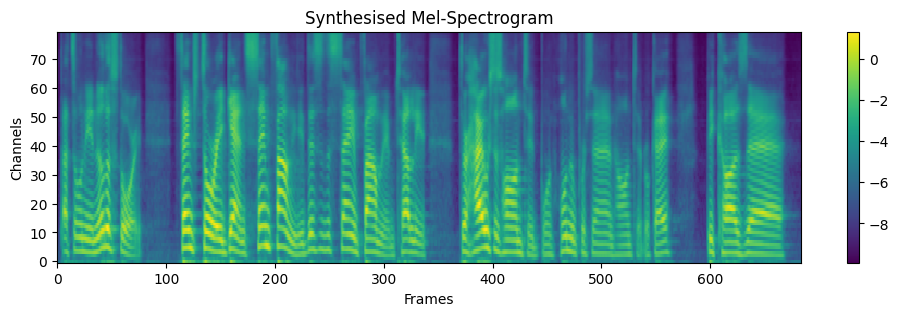

Global seed set to 795


tensor([[[ 2.,  1.,  1.,  3.,  1.,  1.,  1.,  2.,  1.,  1.,  3.,  2.,  1.,  2.,
           1.,  2.,  1.,  1.,  1.,  3.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,
           1.,  3.,  2.,  3.,  1.,  3.,  1.,  1.,  2.,  2.,  1.,  1.,  6.,  1.,
           2.,  3.,  2.,  1.,  2.,  2.,  3.,  1.,  1.,  1.,  5., 15.,  3.,  7.,
           1.,  8.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,
           2.,  2.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,
           1.,  1.,  3.,  1.,  2.,  2.,  4.,  3.,  2.,  4.,  2.,  2.,  1.,  6.,
           1.,  1.,  2.,  2.,  2.,  1.,  2.,  2.,  1.,  3.,  2.,  1.,  1.,  2.,
           2.,  3.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  5.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,
           2.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  3.,  2.,  2.,  1.,  1.,  1.,
           1.,  1.,  3.,  1.,  1.,  1.,  3.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1.,  1., 

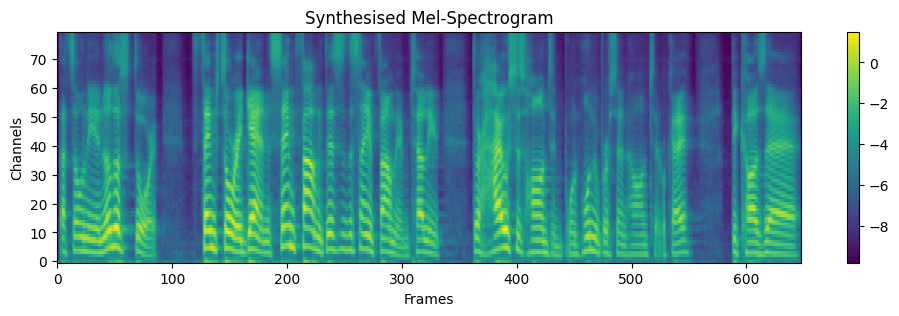

Global seed set to 6567


tensor([[[ 1.,  1.,  1.,  3.,  2.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,
           2.,  1.,  2.,  2.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,
           1.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,
           1.,  1.,  2.,  3.,  2.,  1.,  2.,  3.,  1.,  2.,  7., 13.,  9.,  3.,
           1.,  1.,  2.,  1.,  1.,  2.,  5.,  1.,  2.,  3.,  1.,  1.,  2.,  2.,
           2.,  1.,  1.,  1.,  2.,  3.,  3.,  2.,  1.,  3.,  1.,  2.,  2.,  1.,
           1.,  1.,  1.,  2.,  3.,  2.,  4.,  2.,  2.,  1.,  1.,  1.,  2.,  3.,
           1.,  1.,  3.,  2.,  2.,  1.,  2.,  2.,  1.,  1.,  3.,  1.,  2.,  1.,
           2.,  2.,  1.,  3.,  1.,  3.,  1.,  1.,  1.,  1.,  2.,  3.,  1.,  1.,
           1.,  3.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  2.,  2.,  3.,  2.,  1.,  1.,  3.,  2.,  1.,  1.,  1.,  1.,  2.,
           1.,  1.,  1.,  1.,  1.,  2.,  3.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,
           1.,  2.,  1.,  1.,  1.,  1., 

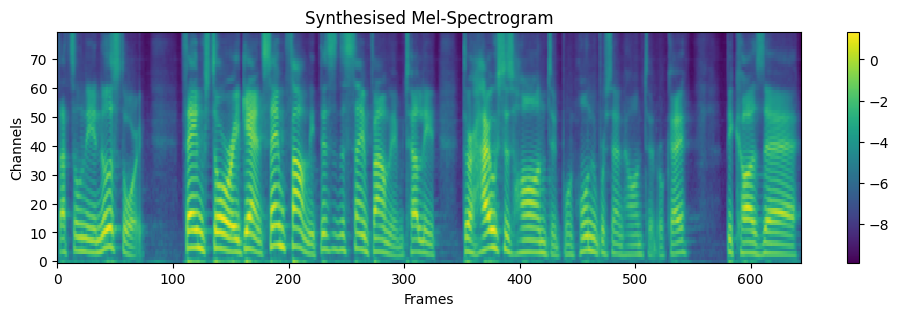

Global seed set to 3807


tensor([[[ 6.,  1.,  1.,  2.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  2.,
           1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,
           1.,  2.,  3.,  3.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,
           1.,  2.,  3.,  3.,  2.,  2.,  2.,  2.,  1.,  3.,  7.,  9.,  4.,  7.,
           3.,  6.,  1.,  1.,  1.,  2.,  3.,  2.,  1.,  2.,  1.,  1.,  2.,  1.,
           3.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  2.,  2.,  2.,  3.,  8.,  2.,  3.,  2.,  2.,  1.,  2.,  2.,  3.,
           1.,  1.,  1.,  2.,  1.,  1.,  2.,  2.,  1.,  2.,  3.,  1.,  2.,  3.,
           1.,  1.,  2.,  2.,  1.,  3.,  1.,  1.,  4.,  1.,  1.,  4.,  1.,  1.,
           1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  4.,  1.,  1.,  2.,  3.,  2.,  2.,  2.,  1.,  4.,
           1.,  1.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,  2.,
           1.,  1.,  1.,  1.,  1.,  1., 

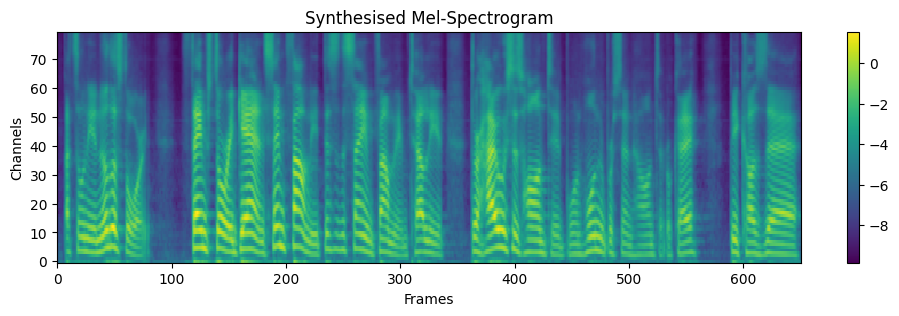

Number of ODE steps: 10
Mean RTF:				0.020956 ± 0.003944
Mean RTF Waveform (incl. vocoder):	0.031546 ± 0.007028


In [32]:
outputs, rtfs = [], []
rtfs_w = []
for i, text in enumerate(tqdm(texts)):
    seed_everything(random.randint(1, 10000))
    output = synthesise(text) #, torch.tensor([15], device=device, dtype=torch.long).unsqueeze(0))
    output['waveform'] = to_waveform(output['mel'], vocoder)

    # Compute Real Time Factor (RTF) with HiFi-GAN
    t = (dt.datetime.now() - output['start_t']).total_seconds()
    rtf_w = t * 22050 / (output['waveform'].shape[-1])

    ## Pretty print
    print(f"{'*' * 53}")
    print(f"Input text - {i}")
    print(f"{'-' * 53}")
    print(output['x_orig'])
    print(f"{'*' * 53}")
    print(f"Phonetised text - {i}")
    print(f"{'-' * 53}")
    print(output['x_phones'])
    print(f"{'*' * 53}")
    print(f"RTF:\t\t{output['rtf']:.6f}")
    print(f"RTF Waveform:\t{rtf_w:.6f}")
    rtfs.append(output['rtf'])
    rtfs_w.append(rtf_w)

    ## Display the synthesised waveform
    plot_spectrogram(output['mel'])
    ipd.display(ipd.Audio(output['waveform'], rate=22050))

    ## Save the generated waveform
    save_to_folder(i, output, OUTPUT_FOLDER)

print(f"Number of ODE steps: {n_timesteps}")
print(f"Mean RTF:\t\t\t\t{np.mean(rtfs):.6f} ± {np.std(rtfs):.6f}")
print(f"Mean RTF Waveform (incl. vocoder):\t{np.mean(rtfs_w):.6f} ± {np.std(rtfs_w):.6f}")

In [20]:
a1 = np.load('/home/smehta/Projects/Matcha-TTS/synth_output/0.npy')
a2 = np.load('/home/smehta/Projects/Matcha-TTS/synth_output/1.npy')